<a href="https://colab.research.google.com/github/ptnv-s/Knee-Abnormality-and-Common-Disorders/blob/colab/InceptionV3_MRNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Based Musculoskeletal Diagnosis, Abnormality and Common Disorders detection using Knee Magnetic Resonance Imaging

---

Magnetic resonance (MR) imaging of the knee is the standard of care imaging modality to evaluate knee disorders, and more musculoskeletal MR examinations are performed on the knee than on any other region of the body.

---

We will be implementing deep learning baselines for detecting general abnormalities and specific diagnoses (anterior cruciate ligament [ACL] tears and meniscal tears) on knee MRI exams.

---

The most common indications for the knee MRI examinations in this study included acute and chronic pain, follow-up or preoperative evaluation, injury/trauma.

---
We have used the [MRNet dataset](https://stanfordmlgroup.github.io/competitions/mrnet/)  which consists of 1,370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams, with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears. The labels were obtained through manual extraction from clinical reports.

---

Examinations were performed with GE scanners (GE Discovery, GE Healthcare, Waukesha, WI) with standard knee MRI coil and a routine non-contrast knee MRI protocol that included the following sequences: coronal T1 weighted, coronal T2 with fat saturation, sagittal proton density (PD) weighted, sagittal T2 with fat saturation, and axial PD weighted with fat saturation. A total of 775 (56.6%) examinations used a 3.0-T magnetic field the remaining used a 1.5-T magnetic field as reported [here](https://stanfordmlgroup.github.io/projects/mrnet/) .

For more details refer to the paper related to this study [here](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002699).

---

Given a MRI scan our deep learning model will be predicting 3 outcomes for knee MRI exams (anterior cruciate ligament [ACL] tears, meniscal tears, and general abnormalities).

#### Importing Basic Libraries

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
import math

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras import backend as K
from keras.layers import Input

##### Defining Custom Metric for Evaluation

In [ ]:
import keras.backend as K
def f1_score(y_true, y_pred):
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))
    if c3 == 0.0 :
        return 0.0
    precision = c1 / c2
    recall = c1 / c3
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score
  

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

##Loading Files for loading Different Planes of Scans of Dataset
As we know from EDA Notebook this dataset has 3 views of Knee since datset has MRI scans namely -

*   Axial
*   Coronal
*   Sagittal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import csv
with open("/content/drive/MyDrive/Medical/MRNet-v1.0/train-abnormal.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    trainAb_labels=[]
    for row in csv_reader:
           trainAb_labels.append(int(row[1]))
print(trainAb_labels)
trainAb_labels= np.array(trainAb_labels)
print(len(trainAb_labels))
with open("/content/drive/MyDrive/Medical/MRNet-v1.0/train-acl.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    trainACL_labels=[]
    for row in csv_reader:
           trainACL_labels.append(int(row[1]))
print(trainAb_labels)
trainACL_labels= np.array(trainACL_labels)
print(len(trainACL_labels))
with open("/content/drive/MyDrive/Medical/MRNet-v1.0/train-meniscus.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    trainMen_labels=[]
    for row in csv_reader:
           trainMen_labels.append(int(row[1]))
print(trainMen_labels)
trainAb_labels= np.array(trainMen_labels)
print(len(trainMen_labels))
with open("/content/drive/MyDrive/Medical/MRNet-v1.0/valid-abnormal.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    testAb_labels=[]
    for row in csv_reader:
           testAb_labels.append(int(row[1]))
print(testAb_labels)
testAb_labels= np.array(testAb_labels)
print(len(testAb_labels))
with open("/content/drive/MyDrive/Medical/MRNet-v1.0/valid-acl.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    testACL_labels=[]
    for row in csv_reader:
           testACL_labels.append(int(row[1]))
print(testACL_labels)
testACL_labels= np.array(testACL_labels)
print(len(testACL_labels))
with open("/content/drive/MyDrive/Medical/MRNet-v1.0/valid-meniscus.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    testMen_labels=[]
    for row in csv_reader:
           testMen_labels.append(int(row[1]))
print(testMen_labels)
testMen_labels= np.array(testMen_labels)
print(len(testMen_labels))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
train_Ab_pred = []
test_Ab_pred = []
train_Men_pred = []
test_Men_pred = []
train_ACL_pred = []
test_ACL_pred = []

##Axial Plane Scans

###Reading train & test data

In [ ]:
axial_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/train/axial/")
axial_dir = [f.lower() for f in axial_dir]   
a=sorted(axial_dir)
axial_list=np.array(a)
axial_reloaded=[]
print(axial_list.shape)
for j in range(1,1131):
    file= "/content/drive/MyDrive/Medical/MRNet-v1.0/train/axial/"+axial_list[j]    
    axial_reloaded.append(np.load(file,allow_pickle='false'))   

axial_reloaded=np.array(axial_reloaded)
print(axial_reloaded.shape)
s=axial_reloaded.shape
print(axial_reloaded[0].shape[0])
train_axial=[]
print(len(axial_reloaded))
for j in range(len(axial_reloaded)):
    mid=math.floor((axial_reloaded[j].shape[0])/2)
    train_axial.append([])    
    
    for n in range(mid-1,mid+2):
         train_axial[j].append(axial_reloaded[j][n])
train_axial=np.array(train_axial)
train_axial=np.reshape(train_axial,(1130,256,256,3))
print(train_axial.shape)
axial_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/valid/axial/")
axial_dir = [f.lower() for f in axial_dir]   
a=sorted(axial_dir)
axialTest_list=np.array(a)
axialTest_reloaded=[]
print(axialTest_list.shape)
for j in range(0,120):
    file= "/content/drive/MyDrive/Medical/MRNet-v1.0/valid/axial/"+axialTest_list[j]
    axialTest_reloaded.append(np.load(file,allow_pickle='false'))   

axialTest_reloaded=np.array(axialTest_reloaded)
print(axialTest_reloaded.shape)
s=axialTest_reloaded.shape
print(axialTest_reloaded[0].shape[0])
test_axial=[]
print(len(axialTest_reloaded))
for j in range(len(axialTest_reloaded)):
    mid=math.floor((axialTest_reloaded[j].shape[0])/2)
    test_axial.append([])    
    for n in range(mid-1,mid+2):
         test_axial[j].append(axialTest_reloaded[j][n])
test_axial=np.array(test_axial)
test_axial=np.reshape(test_axial,(120,256,256,3))
print(test_axial.shape)

(1131,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


(1130,)
44
1130
(1130, 256, 256, 3)
(120,)
(120,)
25
120
(120, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


#### Finetuning InceptionV3 Model for Axial Plane Scanes checking for Meniscus Condition

In [ ]:
input_tensor = Input(shape=(256, 256,3))  
base_model_ax_men = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
print(len(base_model_ax_men.layers))

311


In [ ]:
x = base_model_ax_men.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model_ax_men.input,outputs=predictions)

In [ ]:
for layer in model.layers[:79]:
   layer.trainable = False
for layer in model.layers[79:]:
   layer.trainable = True

In [ ]:
trainMen_labels = np.array(trainMen_labels)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)    
model.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy', f1_score])
history=model.fit(train_axial ,trainMen_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
54/54 [==============================] - 30s 221ms/step - loss: 0.6530 - accuracy: 0.6431 - f1_score: nan - val_loss: 0.6847 - val_accuracy: 0.5614 - val_f1_score: 0.2392
Epoch 2/100
54/54 [==============================] - 8s 145ms/step - loss: 0.5642 - accuracy: 0.6803 - f1_score: nan - val_loss: 0.6616 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 3/100
54/54 [==============================] - 8s 145ms/step - loss: 0.4917 - accuracy: 0.7400 - f1_score: 0.5625 - val_loss: 0.5870 - val_accuracy: 0.7368 - val_f1_score: 0.6996
Epoch 4/100
54/54 [==============================] - 8s 148ms/step - loss: 0.4045 - accuracy: 0.8183 - f1_score: 0.7193 - val_loss: 0.6638 - val_accuracy: 0.6140 - val_f1_score: 0.3657
Epoch 5/100
54/54 [==============================] - 8s 144ms/step - loss: 0.3276 - accuracy: 0.8509 - f1_score: nan - val_loss: 0.6035 - val_accuracy: 0.7018 - val_f1_score: 0.5670
Epoch 6/100
54/54 [==============================] - 8s 145ms/step - loss: 0.2236 - ac

####Plotting accuracy of both training and validation sets per epoch.

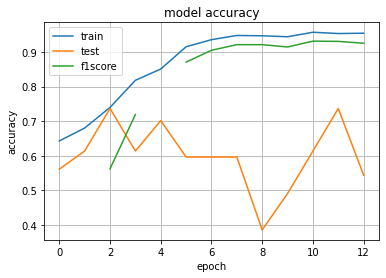

In [ ]:
p = np.array(model.predict(train_axial))
train_Men_pred.append(p)
p = np.array(model.predict(test_axial))
test_Men_pred.append(p)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['f1_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test', 'f1score'], loc='upper left')
plt.grid() 
plt.show()

##### Helper function to clear Memory Utilization enabling it to Work in Colab with K80 GPU and standard RAM allowance.

In [ ]:
import gc
def clean_up(model):
    K.clear_session()
    del model
    gc.collect() #garbage collection
    print("...Finished clean up...")

In [ ]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/model1.h5'
model.save(filename)
print('>Saved %s' % filename)
clean_up(model=model)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/model1.h5
...Finished clean up...


#### Finetuning InceptionV3 Model for Axial Plane Scanes checking for ACL Condition

In [ ]:
input_tensor = Input(shape=(256, 256,3))  
base_model_ax_ACL = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [ ]:
x = base_model_ax_ACL.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model2 = Model(inputs=base_model_ax_ACL.input,outputs=predictions)

In [ ]:
for layer in model2.layers[:79]:
   layer.trainable = False
for layer in model2.layers[79:]:
   layer.trainable = True

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)    
model2.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history2=model2.fit(train_axial ,trainACL_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


54/54 [==============================] - 17s 180ms/step - loss: 0.5110 - accuracy: 0.7866 - f1_score: nan - val_loss: 0.4614 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 8s 151ms/step - loss: 0.3919 - accuracy: 0.8211 - f1_score: nan - val_loss: 0.4399 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 3/100
54/54 [==============================] - 8s 147ms/step - loss: 0.3371 - accuracy: 0.8444 - f1_score: nan - val_loss: 0.4664 - val_accuracy: 0.8070 - val_f1_score: nan
Epoch 4/100
54/54 [==============================] - 8s 148ms/step - loss: 0.2733 - accuracy: 0.8733 - f1_score: nan - val_loss: 0.4540 - val_accuracy: 0.8246 - val_f1_score: nan
Epoch 5/100
54/54 [==============================] - 8s 149ms/step - loss: 0.1999 - accuracy: 0.9254 - f1_score: nan - val_loss: 0.4258 - val_accuracy: 0.7895 - val_f1_score: nan
Epoch 6/100
54/54 [==============================] - 8s 149ms/step - loss: 0.1576 - accuracy: 0.9432 - f1_score: 0.8

4/4 [==============================] - 0s 82ms/step - loss: 1.0063 - accuracy: 0.6500 - f1_score: 0.4326
Train loss: 1.0063023567199707
Train accuracy: 0.6499999761581421


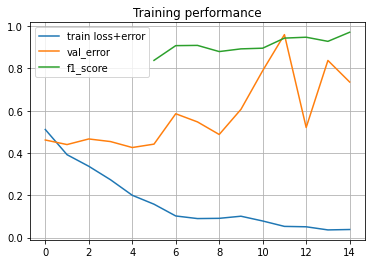

In [ ]:
p = np.array(model2.predict(train_axial))
train_ACL_pred.append(p)
p = np.array(model2.predict(test_axial))
test_ACL_pred.append(p)             
score2 = model2.evaluate(test_axial ,testACL_labels,verbose=1)       
print('Train loss:',score2[0])
print('Train accuracy:',score2[1])                                             
plt.figure()
plt.grid()                                                                                                         
plt.title('Training performance')                          
plt.plot(history2.epoch, history2.history['loss'], label='train loss+error')  
plt.plot(history2.epoch, history2.history['val_loss'], label='val_error')
plt.plot(history2.epoch, history2.history['f1_score'], label='f1_score')
plt.legend()

In [ ]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/model2.h5'
model2.save(filename)
print('>Saved %s' % filename)
clean_up(model=model2)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/model2.h5
...Finished clean up...


#### Finetuning InceptionV3 Model for Axial Plane Scanes checking for Abnormal Condition

In [ ]:
input_tensor = Input(shape=(256, 256,3))  
base_model_ax_AB = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [ ]:
x = base_model_ax_AB.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model3 = Model(inputs=base_model_ax_AB.input,outputs=predictions)

In [ ]:
for layer in model3.layers[:79]:
   layer.trainable = False
for layer in model3.layers[79:]:
   layer.trainable = True

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)    
model3.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history3=model3.fit(train_axial ,trainAb_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


54/54 [==============================] - 16s 174ms/step - loss: 0.6459 - accuracy: 0.6328 - f1_score: nan - val_loss: 0.6877 - val_accuracy: 0.5614 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 8s 150ms/step - loss: 0.5585 - accuracy: 0.6925 - f1_score: nan - val_loss: 0.6733 - val_accuracy: 0.5789 - val_f1_score: 0.4637
Epoch 3/100
54/54 [==============================] - 8s 151ms/step - loss: 0.5014 - accuracy: 0.7344 - f1_score: nan - val_loss: 0.8046 - val_accuracy: 0.4211 - val_f1_score: 0.5341
Epoch 4/100
54/54 [==============================] - 8s 148ms/step - loss: 0.4489 - accuracy: 0.7847 - f1_score: 0.6658 - val_loss: 0.6323 - val_accuracy: 0.5789 - val_f1_score: 0.5349
Epoch 5/100
54/54 [==============================] - 8s 151ms/step - loss: 0.3562 - accuracy: 0.8341 - f1_score: 0.7540 - val_loss: 0.7251 - val_accuracy: 0.5439 - val_f1_score: 0.5153
Epoch 6/100
54/54 [==============================] - 8s 149ms/step - loss: 0.2787 - accuracy: 0.89

4/4 [==============================] - 0s 83ms/step - loss: 1.5875 - accuracy: 0.5917 - f1_score: nan
Test loss: 1.587497591972351
Test accuracy: 0.5916666388511658


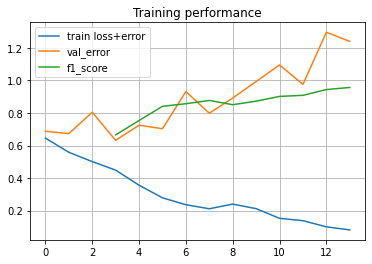

In [ ]:
p = np.array(model3.predict(train_axial))
train_Ab_pred.append(p)
p = np.array(model3.predict(test_axial))
test_Ab_pred.append(p)               
score3 = model3.evaluate(test_axial ,testAb_labels,verbose=1)       
print('Test loss:',score3[0])
print('Test accuracy:',score3[1])                                                             
plt.figure()
plt.grid()                                                                                                          
plt.title('Training performance')                          
plt.plot(history3.epoch, history3.history['loss'], label='train loss+error')  
plt.plot(history3.epoch, history3.history['val_loss'], label='val_error') 
plt.plot(history3.epoch, history3.history['f1_score'], label='f1_score') 
plt.legend()

In [ ]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/model3.h5'
model3.save(filename)
print('>Saved %s' % filename)
clean_up(model=model3)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/model3.h5
...Finished clean up...


In [ ]:
del train_axial
del test_axial
del axial_dir
del axial_reloaded
del axialTest_reloaded
del axial_list
del axialTest_list
del model
del model2
del model3
del base_model_ax_men
del base_model_ax_ACL
del base_model_ax_AB
del p

##Coronal Plane Scans

###Reading train & test data

In [ ]:

coronal_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/train/coronal/")
coronal_dir = [f.lower() for f in coronal_dir]   
c=sorted(coronal_dir)
coronal_list=np.array(c)
coronal_reloaded=[]
print(coronal_list.shape)
for j in range(1,1131):
    file2= "/content/drive/MyDrive/Medical/MRNet-v1.0/train/coronal/"+coronal_list[j]
    coronal_reloaded.append(np.load(file2,allow_pickle='false'))
coronal_reloaded=np.array(coronal_reloaded)
print(coronal_reloaded.shape)
train_coronal=[]
for j in range(len(coronal_reloaded)):
    mid2=math.floor((coronal_reloaded[j].shape[0])/2)
    train_coronal.append([])
    for n in range(mid2-1,mid2+2):
         train_coronal[j].append(coronal_reloaded[j][n])
train_coronal=np.array(train_coronal)
train_coronal=np.reshape(train_coronal,(1130,256,256,3))
print(train_coronal.shape)
coronal_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/valid/coronal/")
coronal_dir = [f.lower() for f in coronal_dir]   
c=sorted(coronal_dir)
coronalTest_list=np.array(c)
coronalTest_reloaded=[]
print(coronalTest_list.shape)
for j in range(0,120):
    file2= "/content/drive/MyDrive/Medical/MRNet-v1.0/valid/coronal/"+coronalTest_list[j]
    coronalTest_reloaded.append(np.load(file2,allow_pickle='false'))
coronalTest_reloaded=np.array(coronalTest_reloaded)
print(coronalTest_reloaded.shape)
test_coronal=[]
for j in range(len(coronalTest_reloaded)):
    mid2=math.floor((coronalTest_reloaded[j].shape[0])/2)
    test_coronal.append([])
    for n in range(mid2-1,mid2+2):
         test_coronal[j].append(coronalTest_reloaded[j][n])
test_coronal=np.array(test_coronal)
test_coronal=np.reshape(test_coronal,(120,256,256,3))
print(test_coronal.shape)

(1131,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


(1130,)
(1130, 256, 256, 3)
(120,)
(120,)
(120, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


#### Finetuning InceptionV3 Model for Coronal Plane Scanes checking for Meniscus Condition

In [ ]:
input_tensor = Input(shape=(256, 256,3))  
base_model_Co_Men = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [ ]:
x = base_model_Co_Men.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model4 = Model(inputs=base_model_Co_Men.input,outputs=predictions)

In [ ]:
for layer in model4.layers[:79]:
   layer.trainable = False
for layer in model4.layers[79:]:
   layer.trainable = True

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)    
model4.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history4=model4.fit(train_coronal ,trainMen_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
54/54 [==============================] - 16s 171ms/step - loss: 0.6583 - accuracy: 0.6375 - f1_score: nan - val_loss: 0.6859 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 8s 145ms/step - loss: 0.6150 - accuracy: 0.6570 - f1_score: nan - val_loss: 0.7155 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 3/100
54/54 [==============================] - 8s 145ms/step - loss: 0.5595 - accuracy: 0.6971 - f1_score: nan - val_loss: 0.7164 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 4/100
54/54 [==============================] - 8s 148ms/step - loss: 0.5176 - accuracy: 0.7428 - f1_score: nan - val_loss: 0.6653 - val_accuracy: 0.5789 - val_f1_score: 0.3947
Epoch 5/100
54/54 [==============================] - 8s 149ms/step - loss: 0.4486 - accuracy: 0.7856 - f1_score: 0.6616 - val_loss: 0.6555 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 6/100
54/54 [==============================] - 8s 149ms/step - loss: 0.3606 - accuracy: 0.83

4/4 [==============================] - 0s 84ms/step - loss: 1.5605 - accuracy: 0.5667 - f1_score: nan
Test loss: 1.560547947883606
Test accuracy: 0.5666666626930237


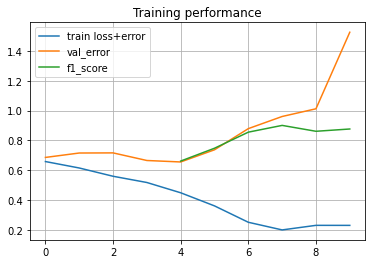

In [ ]:
p = np.array(model4.predict(train_coronal))
train_Men_pred.append(p)
p = np.array(model4.predict(test_coronal))
test_Men_pred.append(p)
score4 = model4.evaluate(test_coronal ,testMen_labels,verbose=1)       
print('Test loss:',score4[0])
print('Test accuracy:',score4[1])                                                                    
plt.figure()
plt.grid()                                                                                                          
plt.title('Training performance')                          
plt.plot(history4.epoch, history4.history['loss'], label='train loss+error')  
plt.plot(history4.epoch, history4.history['val_loss'], label='val_error')  
plt.plot(history4.epoch, history4.history['f1_score'], label='f1_score')  
plt.legend()

In [ ]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/model4.h5'
model4.save(filename)
print('>Saved %s' % filename)
clean_up(model=model4)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/model4.h5
...Finished clean up...


#### Finetuning InceptionV3 Model for Coronal Plane Scanes checking for ACL Condition

In [ ]:
input_tensor = Input(shape=(256, 256,3))  
base_model_Co_ACL = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [ ]:
x = base_model_Co_ACL.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model5 = Model(inputs=base_model_Co_ACL.input,outputs=predictions)

In [ ]:
for layer in model5.layers[:79]:
   layer.trainable = False
for layer in model5.layers[79:]:
   layer.trainable = True

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)    
model5.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history5=model5.fit(train_coronal ,trainACL_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
54/54 [==============================] - 16s 175ms/step - loss: 0.5099 - accuracy: 0.7903 - f1_score: nan - val_loss: 0.4117 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 8s 148ms/step - loss: 0.4694 - accuracy: 0.8136 - f1_score: nan - val_loss: 0.4262 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 3/100
54/54 [==============================] - 8s 149ms/step - loss: 0.4340 - accuracy: 0.8127 - f1_score: nan - val_loss: 0.3856 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 4/100
54/54 [==============================] - 8s 152ms/step - loss: 0.3692 - accuracy: 0.8267 - f1_score: nan - val_loss: 0.4443 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 5/100
54/54 [==============================] - 8s 150ms/step - loss: 0.3027 - accuracy: 0.8611 - f1_score: nan - val_loss: 0.5283 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 6/100
54/54 [==============================] - 8s 150ms/step - loss: 0.2208 - accuracy: 0.9208 - f

4/4 [==============================] - 0s 84ms/step - loss: 0.9644 - accuracy: 0.6083 - f1_score: 0.3022
Test loss: 0.9643641114234924
Test accuracy: 0.6083333492279053


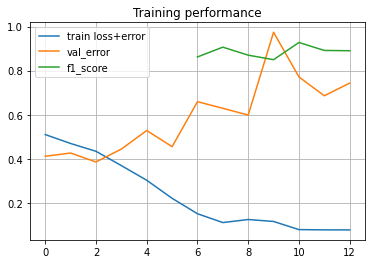

In [ ]:
p = np.array(model5.predict(train_coronal))
train_ACL_pred.append(p)
p = np.array(model5.predict(test_coronal, verbose=1))
test_ACL_pred.append(p)                   
score5 = model5.evaluate(test_coronal ,testACL_labels,verbose=1)       
print('Test loss:',score5[0])
print('Test accuracy:',score5[1])                                                               
plt.figure()
plt.grid()                                                                                                        
plt.title('Training performance')                          
plt.plot(history5.epoch, history5.history['loss'], label='train loss+error')  
plt.plot(history5.epoch, history5.history['val_loss'], label='val_error') 
plt.plot(history5.epoch, history5.history['f1_score'], label='f1_score') 
plt.legend()

In [ ]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/model5.h5'
model5.save(filename)
print('>Saved %s' % filename)
clean_up(model=model5)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/model5.h5
...Finished clean up...


#### Finetuning InceptionV3 Model for Coronal Plane Scanes checking for Abnormal Condition

In [ ]:
input_tensor = Input(shape=(256, 256,3))  
base_model_Co_Ab = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [ ]:
x = base_model_Co_Ab.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model6 = Model(inputs=base_model_Co_Ab.input,outputs=predictions)

In [ ]:
for layer in model6.layers[:79]:
   layer.trainable = False
for layer in model6.layers[79:]:
   layer.trainable = True

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)    
model6.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history6=model6.fit(train_coronal ,trainAb_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


54/54 [==============================] - 17s 175ms/step - loss: 0.6645 - accuracy: 0.6198 - f1_score: nan - val_loss: 0.7840 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 8s 149ms/step - loss: 0.6293 - accuracy: 0.6580 - f1_score: nan - val_loss: 0.7451 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 3/100
54/54 [==============================] - 8s 153ms/step - loss: 0.5791 - accuracy: 0.6822 - f1_score: nan - val_loss: 0.7290 - val_accuracy: 0.6316 - val_f1_score: nan
Epoch 4/100
54/54 [==============================] - 8s 153ms/step - loss: 0.5155 - accuracy: 0.7185 - f1_score: nan - val_loss: 0.6813 - val_accuracy: 0.5965 - val_f1_score: nan
Epoch 5/100
54/54 [==============================] - 8s 151ms/step - loss: 0.4684 - accuracy: 0.7679 - f1_score: 0.6162 - val_loss: 0.6885 - val_accuracy: 0.5439 - val_f1_score: 0.4122
Epoch 6/100
54/54 [==============================] - 8s 151ms/step - loss: 0.3890 - accuracy: 0.8257 - f1_scor

4/4 [==============================] - 0s 82ms/step - loss: 2.5337 - accuracy: 0.3000 - f1_score: nan
Test loss: 2.5337178707122803
Test accuracy: 0.30000001192092896


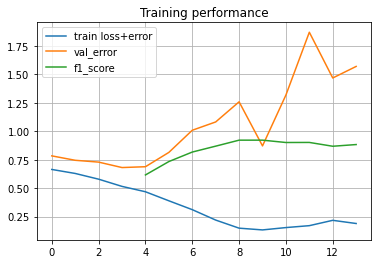

In [ ]:
p = np.array(model6.predict(train_coronal))
train_Ab_pred.append(p)
p = np.array(model6.predict(test_coronal))
test_Ab_pred.append(p)                      
score6 = model6.evaluate(test_coronal ,testAb_labels,verbose=1)       
print('Test loss:',score6[0])
print('Test accuracy:',score6[1])                                                                   
plt.figure()
plt.grid()                                                                                                         
plt.title('Training performance')                          
plt.plot(history6.epoch, history6.history['loss'], label='train loss+error')  
plt.plot(history6.epoch, history6.history['val_loss'], label='val_error')   
plt.plot(history6.epoch, history6.history['f1_score'], label='f1_score')   
plt.legend()

In [ ]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/model6.h5'
model6.save(filename)
print('>Saved %s' % filename)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/model6.h5


In [ ]:
clean_up(model=model6)

...Finished clean up...


In [ ]:
del train_coronal
del test_coronal
del coronal_dir
del coronal_reloaded
del coronalTest_reloaded
del coronal_list
del coronalTest_list
del model4
del model5
del model6
del base_model_Co_Men
del base_model_Co_ACL
del base_model_Co_Ab
del p

##Sagittal Planes Scans

###Reading train & test data

In [ ]:
axial_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/train/axial/")
axial_dir = [f.lower() for f in axial_dir]   
a=sorted(axial_dir)
axial_list=np.array(a)
axial_reloaded=[]
print(axial_list.shape)
for j in range(1,1131):
    file= "/content/drive/MyDrive/Medical/MRNet-v1.0/train/axial/"+axial_list[j]    
    axial_reloaded.append(np.load(file,allow_pickle='false'))   
axial_reloaded=np.array(axial_reloaded)
print(axial_reloaded.shape)
s=axial_reloaded.shape
print(axial_reloaded[0].shape[0])
train_axial=[]
print(len(axial_reloaded))
for j in range(len(axial_reloaded)):
    mid=math.floor((axial_reloaded[j].shape[0])/2)
    train_axial.append([])      
    for n in range(mid-1,mid+2):
         train_axial[j].append(axial_reloaded[j][n])
train_axial=np.array(train_axial)
train_axial=np.reshape(train_axial,(1130,256,256,3))
print(train_axial.shape)
axial_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/valid/axial/")
axial_dir = [f.lower() for f in axial_dir]   
a=sorted(axial_dir)
axialTest_list=np.array(a)
axialTest_reloaded=[]
print(axialTest_list.shape)
for j in range(0,120):
    file= "/content/drive/MyDrive/Medical/MRNet-v1.0/valid/axial/"+axialTest_list[j]
    axialTest_reloaded.append(np.load(file,allow_pickle='false'))   
axialTest_reloaded=np.array(axialTest_reloaded)
print(axialTest_reloaded.shape)
s=axialTest_reloaded.shape
print(axialTest_reloaded[0].shape[0])
test_axial=[]
print(len(axialTest_reloaded))
for j in range(len(axialTest_reloaded)):
    mid=math.floor((axialTest_reloaded[j].shape[0])/2)
    test_axial.append([])    
    for n in range(mid-1,mid+2):
         test_axial[j].append(axialTest_reloaded[j][n])
test_axial=np.array(test_axial)
test_axial=np.reshape(test_axial,(120,256,256,3))
print(test_axial.shape)

(1131,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


(1130,)
44
1130
(1130, 256, 256, 3)
(120,)
(120,)
25
120
(120, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
sagittal_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/train/sagittal/")
sagittal_dir = [f.lower() for f in sagittal_dir]   
c=sorted(sagittal_dir)
sagittal_list=np.array(c)
sagittal_reloaded=[]
print(sagittal_list.shape)
for j in range(1,1131):
    file2= "/content/drive/MyDrive/Medical/MRNet-v1.0/train/sagittal/"+sagittal_list[j]
    sagittal_reloaded.append(np.load(file2,allow_pickle='false'))
sagittal_reloaded=np.array(sagittal_reloaded)
print(sagittal_reloaded.shape)
train_sagittal=[]
for j in range(len(sagittal_reloaded)):
    mid2=math.floor((sagittal_reloaded[j].shape[0])/2)
    train_sagittal.append([])
   
    for n in range(mid2-1,mid2+2):
         train_sagittal[j].append(sagittal_reloaded[j][n])

train_sagittal=np.array(train_sagittal)
train_sagittal=np.reshape(train_sagittal,(1130,256,256,3))
print(train_sagittal.shape)
sagittal_dir = os.listdir("/content/drive/MyDrive/Medical/MRNet-v1.0/valid/sagittal/")
sagittal_dir = [f.lower() for f in sagittal_dir]   
c=sorted(sagittal_dir)
sagittalTest_list=np.array(c)
sagittalTest_reloaded=[]
print(sagittalTest_list.shape)
for j in range(0,120):
    file2= "/content/drive/MyDrive/Medical/MRNet-v1.0/valid/sagittal/"+sagittalTest_list[j]
    sagittalTest_reloaded.append(np.load(file2,allow_pickle='false'))
sagittalTest_reloaded=np.array(sagittalTest_reloaded)
print(sagittalTest_reloaded.shape)
test_sagittal=[]
for j in range(len(sagittalTest_reloaded)):
    mid2=math.floor((sagittalTest_reloaded[j].shape[0])/2)
    test_sagittal.append([])
    for n in range(mid2-1,mid2+2):
         test_sagittal[j].append(sagittalTest_reloaded[j][n])
test_sagittal=np.array(test_sagittal)
test_sagittal=np.reshape(test_sagittal,(120,256,256,3))
print(test_sagittal.shape)

(1131,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


(1130,)
(1130, 256, 256, 3)
(120,)
(120,)
(120, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


#### Finetuning InceptionV3 Model for Sagittal Plane Scanes checking for Mensical Condition

In [ ]:
input_tensor = Input(shape=(256, 256,3))  
base_model_Sa_Men = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [ ]:
x = base_model_Sa_Men.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model7 = Model(inputs=base_model_Sa_Men.input,outputs=predictions)

In [ ]:
for layer in model7.layers[:79]:
   layer.trainable = False
for layer in model7.layers[79:]:
   layer.trainable = True

In [ ]:
trainMen_labels = np.array(trainMen_labels)

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)    
model7.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history7=model7.fit(train_sagittal ,trainMen_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
54/54 [==============================] - 18s 177ms/step - loss: 0.6609 - accuracy: 0.6188 - f1_score: nan - val_loss: 0.7196 - val_accuracy: 0.6140 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 8s 146ms/step - loss: 0.5935 - accuracy: 0.6822 - f1_score: nan - val_loss: 0.7066 - val_accuracy: 0.5088 - val_f1_score: 0.3379
Epoch 3/100
54/54 [==============================] - 8s 148ms/step - loss: 0.5384 - accuracy: 0.7083 - f1_score: nan - val_loss: 0.7718 - val_accuracy: 0.5789 - val_f1_score: nan
Epoch 4/100
54/54 [==============================] - 8s 148ms/step - loss: 0.4616 - accuracy: 0.7707 - f1_score: 0.6412 - val_loss: 0.7132 - val_accuracy: 0.5789 - val_f1_score: 0.4769
Epoch 5/100
54/54 [==============================] - 8s 146ms/step - loss: 0.3456 - accuracy: 0.8527 - f1_score: 0.7771 - val_loss: 1.0457 - val_accuracy: 0.5789 - val_f1_score: nan
Epoch 6/100
54/54 [==============================] - 8s 147ms/step - loss: 0.2520 - accuracy

4/4 [==============================] - 0s 82ms/step - loss: 0.9581 - accuracy: 0.6000 - f1_score: 0.4262
Test loss: 0.9580651521682739
Test accuracy: 0.6000000238418579


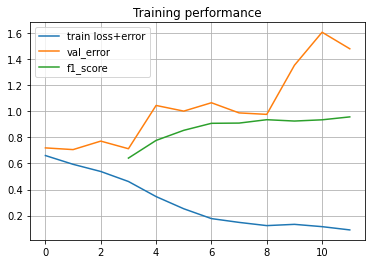

In [ ]:
p = np.array(model7.predict(train_sagittal))
train_Men_pred.append(p)
p = np.array(model7.predict(test_sagittal))
test_Men_pred.append(p)                         
score7 = model7.evaluate(test_sagittal ,testMen_labels,verbose=1)       
print('Test loss:',score7[0])
print('Test accuracy:',score7[1])                                                                  
plt.figure()
plt.grid()                                                                                                        
plt.title('Training performance')                          
plt.plot(history7.epoch, history7.history['loss'], label='train loss+error')  
plt.plot(history7.epoch, history7.history['val_loss'], label='val_error')
plt.plot(history7.epoch, history7.history['f1_score'], label='f1_score')
plt.legend()

In [ ]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/model7.h5'
model7.save(filename)
print('>Saved %s' % filename)
clean_up(model=model7)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/model7.h5
...Finished clean up...


#### Finetuning InceptionV3 Model for Sagittal Plane Scanes checking for ACL Condition

In [ ]:
input_tensor = Input(shape=(256, 256,3))  
base_model_Sa_ACL = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [ ]:
x = base_model_Sa_ACL.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model8 = Model(inputs=base_model_Sa_ACL.input,outputs=predictions)

In [ ]:
for layer in model8.layers[:79]:
   layer.trainable = False
for layer in model8.layers[79:]:
   layer.trainable = True

In [ ]:
early_stopping_monitor = EarlyStopping(patience=5)
model8.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history8=model8.fit(train_sagittal ,trainACL_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
54/54 [==============================] - 17s 174ms/step - loss: 0.5053 - accuracy: 0.7810 - f1_score: nan - val_loss: 0.4784 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 8s 145ms/step - loss: 0.4114 - accuracy: 0.8164 - f1_score: nan - val_loss: 0.4667 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 3/100
54/54 [==============================] - 8s 145ms/step - loss: 0.3585 - accuracy: 0.8248 - f1_score: nan - val_loss: 0.4507 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 4/100
54/54 [==============================] - 8s 149ms/step - loss: 0.2874 - accuracy: 0.8537 - f1_score: nan - val_loss: 0.5721 - val_accuracy: 0.8421 - val_f1_score: nan
Epoch 5/100
54/54 [==============================] - 8s 149ms/step - loss: 0.2010 - accuracy: 0.9087 - f1_score: nan - val_loss: 0.5893 - val_accuracy: 0.7719 - val_f1_score: nan
Epoch 6/100
54/54 [==============================] - 8s 147ms/step - loss: 0.1442 - accuracy: 0.9562 - f

4/4 [==============================] - 0s 84ms/step - loss: 1.1941 - accuracy: 0.6500 - f1_score: 0.3250
Test loss: 1.1941382884979248
Test accuracy: 0.6499999761581421


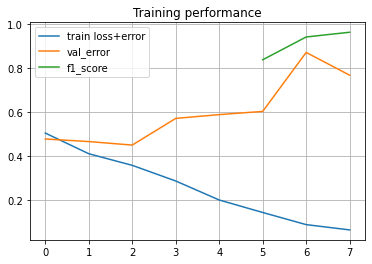

In [ ]:
p = np.array(model8.predict(train_sagittal))
train_ACL_pred.append(p)
p = np.array(model8.predict(test_sagittal))
test_ACL_pred.append(p)                         
score8 = model8.evaluate(test_sagittal ,testACL_labels,verbose=1)       
print('Test loss:',score8[0])
print('Test accuracy:',score8[1])                                                                   
plt.figure()
plt.grid()                                                                                                         
plt.title('Training performance')                          
plt.plot(history8.epoch, history8.history['loss'], label='train loss+error')  
plt.plot(history8.epoch, history8.history['val_loss'], label='val_error')
plt.plot(history8.epoch, history8.history['f1_score'], label='f1_score')
plt.legend()

In [ ]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/model8.h5'
model8.save(filename)
print('>Saved %s' % filename)
clean_up(model=model8)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/model8.h5
...Finished clean up...


#### Finetuning InceptionV3 Model for Sagittal Plane Scanes checking for Abnormal Condition

In [ ]:
input_tensor = Input(shape=(256, 256,3))  
base_model_Sa_Ab = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [ ]:
x = base_model_Sa_Ab.output
x = GlobalAveragePooling2D()(x)
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
model9 = Model(inputs=base_model_Sa_Ab.input,outputs=predictions)

In [ ]:
for layer in model9.layers[:79]:
   layer.trainable = False
for layer in model9.layers[79:]:
   layer.trainable = True

In [ ]:
early_stopping_monitor = EarlyStopping(patience=10)    
model9.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history9=model9.fit(train_sagittal ,trainAb_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


54/54 [==============================] - 17s 174ms/step - loss: 0.6741 - accuracy: 0.6104 - f1_score: nan - val_loss: 0.6462 - val_accuracy: 0.6491 - val_f1_score: nan
Epoch 2/100
54/54 [==============================] - 8s 145ms/step - loss: 0.5791 - accuracy: 0.6906 - f1_score: nan - val_loss: 0.6814 - val_accuracy: 0.5439 - val_f1_score: nan
Epoch 3/100
54/54 [==============================] - 8s 147ms/step - loss: 0.5141 - accuracy: 0.7409 - f1_score: 0.5713 - val_loss: 0.7124 - val_accuracy: 0.5439 - val_f1_score: nan
Epoch 4/100
54/54 [==============================] - 8s 150ms/step - loss: 0.4354 - accuracy: 0.8062 - f1_score: 0.6796 - val_loss: 0.8097 - val_accuracy: 0.5614 - val_f1_score: 0.3146
Epoch 5/100
54/54 [==============================] - 8s 148ms/step - loss: 0.3332 - accuracy: 0.8518 - f1_score: 0.7708 - val_loss: 0.9153 - val_accuracy: 0.6316 - val_f1_score: nan
Epoch 6/100
54/54 [==============================] - 8s 151ms/step - loss: 0.2777 - accuracy: 0.8900 - f

4/4 [==============================] - 0s 81ms/step - loss: 1.3251 - accuracy: 0.4833 - f1_score: 0.5399
Test loss: 1.325088620185852
Test accuracy: 0.4833333194255829


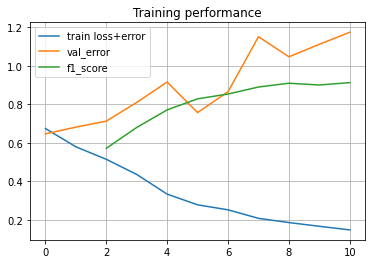

In [ ]:
p = np.array(model9.predict(train_sagittal))
train_Ab_pred.append(p)
p = np.array(model9.predict(test_sagittal))
test_Ab_pred.append(p)                       
score9 = model9.evaluate(test_sagittal ,testAb_labels,verbose=1)       
print('Test loss:',score9[0])
print('Test accuracy:',score9[1])                                                                  
plt.figure()
plt.grid()                                                                                                        
plt.title('Training performance')                          
plt.plot(history9.epoch, history9.history['loss'], label='train loss+error')  
plt.plot(history9.epoch, history9.history['val_loss'], label='val_error')
plt.plot(history9.epoch, history9.history['f1_score'], label='f1_score')
plt.legend()

In [ ]:
filename = '/content/drive/MyDrive/Medical/MRNET MODEL/model9.h5'
model9.save(filename)
print('>Saved %s' % filename)
clean_up(model=model9)

>Saved /content/drive/MyDrive/Medical/MRNET MODEL/model9.h5
...Finished clean up...


In [ ]:
del train_sagittal
del test_sagittal
del sagittal_dir
del sagittal_reloaded
del sagittalTest_reloaded
del sagittal_list
del sagittalTest_list
del model7
del model8
del model9
del base_model_Sa_Men
del base_model_Sa_ACL
del base_model_Sa_Ab
del p

##Ensembling

---
We ensemble the models for each state detection for three planes Axial,Coronal and Sagittal respectively and train a Sequential model with input being probabitity of condition detection by indiviual model and output again being probability person has the condition. We give original label for evaluation of the method.

#### Meniscal Condition Detection

In [ ]:
train_Men_pred = np.array(train_Men_pred)
print(train_Men_pred.shape)
test_Men_pred = np.array(test_Men_pred)
print(test_Men_pred.shape)
train_Men_pred = train_Men_pred.reshape((1130,3))
test_Men_pred = test_Men_pred.reshape((120,3))
print(train_Men_pred)

(3, 1130, 1)
(3, 120, 1)
[[5.0918199e-04 8.7494183e-01 1.8212888e-04]
 [7.5798184e-01 2.7328834e-02 2.0606802e-01]
 [2.5894484e-01 2.1132953e-02 3.5780653e-01]
 ...
 [5.3701985e-01 9.4485426e-01 1.6685486e-01]
 [4.5832947e-01 2.6462825e-02 3.3137968e-04]
 [6.1771250e-01 9.8441398e-01 9.8512846e-01]]


In [ ]:
menModel = Sequential()
menModel.add(Dense(1, activation='sigmoid', input_dim=3))
menModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_score])
h = menModel.fit(train_Men_pred, trainMen_labels, batch_size=32, epochs=50, verbose=1)

Epoch 1/50
36/36 [==============================] - 19s 4ms/step - loss: 0.6980 - acc: 0.5106 - f1_score: nan
Epoch 2/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6907 - acc: 0.5699 - f1_score: 0.2979
Epoch 3/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6846 - acc: 0.5788 - f1_score: nan
Epoch 4/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6794 - acc: 0.5938 - f1_score: nan
Epoch 5/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6750 - acc: 0.6053 - f1_score: nan
Epoch 6/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6715 - acc: 0.6150 - f1_score: nan
Epoch 7/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6686 - acc: 0.6301 - f1_score: nan
Epoch 8/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6661 - acc: 0.6442 - f1_score: nan
Epoch 9/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6640 - acc: 0.6487 - f1_score: nan
Epoch 10/50
36/

4/4 [==============================] - 0s 6ms/step - loss: 0.7066 - acc: 0.5667 - f1_score: nan   
Loss:  0.7065783143043518
Accuracy:  0.5666666626930237


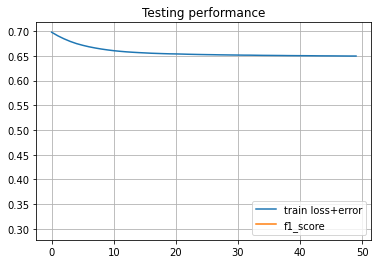

In [ ]:
loss, acc, f1 = menModel.evaluate(test_Men_pred, testMen_labels)
p1 = menModel.predict(test_Men_pred)
print("Loss: ", loss)
print('Accuracy: ', acc)                                                               
plt.figure()
plt.grid()                                                                                                        
plt.title('Testing performance')                          
plt.plot(h.epoch, h.history['loss'], label='train loss+error')  
plt.plot(h.epoch, h.history['f1_score'], label='f1_score')
plt.legend()

In [ ]:
del train_Men_pred
del menModel

#### ACL Condition Detection

In [ ]:
train_ACL_pred = np.array(train_ACL_pred)
print(train_ACL_pred.shape)
test_ACL_pred = np.array(test_ACL_pred)
print(test_Men_pred.shape)
train_ACL_pred = train_ACL_pred.reshape((1130,3))
test_ACL_pred = test_ACL_pred.reshape((120,3))
print(test_ACL_pred)

(3, 1130, 1)
(120, 3)
[[3.00914864e-03 2.40274258e-05 2.62965143e-01]
 [3.30468565e-02 5.61336601e-05 5.02313515e-06]
 [1.94179770e-02 1.76913172e-01 9.45879042e-01]
 [6.82719378e-03 6.31014444e-03 6.47995412e-01]
 [2.20308602e-02 8.14702570e-01 1.80345159e-02]
 [6.18691323e-04 5.91431861e-04 8.86413515e-01]
 [9.20860171e-01 1.28431302e-05 2.51299113e-01]
 [9.71716642e-01 1.80390179e-02 3.01435404e-02]
 [6.62441179e-03 7.94544458e-01 3.52199240e-05]
 [1.21355779e-03 2.20357217e-02 2.29538674e-03]
 [3.60694528e-01 1.68163516e-02 6.55690953e-02]
 [4.36392814e-01 3.13151836e-01 2.19838005e-02]
 [1.99564755e-01 1.36444317e-02 2.92272889e-04]
 [9.67415631e-01 9.48746502e-01 8.51083398e-01]
 [2.55065528e-03 3.27981561e-01 9.74657476e-01]
 [9.29386914e-01 6.54806793e-01 2.30390385e-01]
 [4.42239642e-03 9.42228973e-01 1.45296578e-03]
 [9.43519056e-01 7.93732819e-04 3.52278441e-01]
 [5.20509303e-01 1.64231420e-01 2.26047352e-01]
 [4.26141638e-03 8.29630733e-01 7.02219069e-01]
 [2.77273983e-01 6

In [ ]:
train_ACL_pred

array([[4.3625683e-03, 9.8585087e-01, 1.2728321e-02],
       [5.1054707e-05, 2.3338334e-05, 8.3415938e-04],
       [2.4134900e-04, 9.3528557e-05, 1.5987858e-02],
       ...,
       [2.4810998e-02, 1.6968727e-02, 2.6325445e-06],
       [4.3958016e-03, 8.5132927e-01, 4.5161352e-02],
       [9.5084868e-02, 9.1162145e-02, 5.2696294e-01]], dtype=float32)

In [ ]:
menModel = Sequential()
menModel.add(Dense(1, activation='sigmoid', input_dim=3))

menModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_score])
h = menModel.fit(train_ACL_pred, trainACL_labels, batch_size=32, epochs=50, verbose=1)

Epoch 1/50
36/36 [==============================] - 1s 4ms/step - loss: 0.7156 - accuracy: 0.4991 - f1_score: nan
Epoch 2/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6990 - accuracy: 0.5549 - f1_score: nan
Epoch 3/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6836 - accuracy: 0.5903 - f1_score: nan
Epoch 4/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6692 - accuracy: 0.6319 - f1_score: nan
Epoch 5/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6558 - accuracy: 0.6761 - f1_score: nan
Epoch 6/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.7106 - f1_score: nan
Epoch 7/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.7212 - f1_score: nan
Epoch 8/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6212 - accuracy: 0.7354 - f1_score: nan
Epoch 9/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6113 - accurac

4/4 [==============================] - 0s 5ms/step - loss: 0.8254 - accuracy: 0.5500 - f1_score: nan   
Loss:  0.8254281282424927
Accuracy:  0.550000011920929


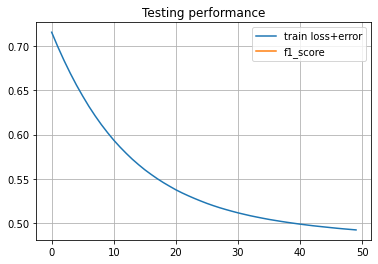

In [ ]:
loss, acc, f1 = menModel.evaluate(test_ACL_pred, testACL_labels)
p2 = menModel.predict(test_ACL_pred)
print("Loss: ", loss)
print('Accuracy: ', acc)
                                          
plt.figure()
plt.grid()                                              
                                                            
plt.title('Testing performance')                          
plt.plot(h.epoch, h.history['loss'], label='train loss+error')  
plt.plot(h.epoch, h.history['f1_score'], label='f1_score')
plt.legend()

In [ ]:
del train_ACL_pred
del menModel

#### Abnormal Condition Detection

In [ ]:
np.isnan(np.sum(trainAb_labels))

False

In [ ]:
train_Ab_pred = np.array(train_Ab_pred)
print(train_Ab_pred.shape)
test_Ab_pred = np.array(test_Ab_pred)
print(test_Ab_pred.shape)

train_Ab_pred = train_Ab_pred.reshape((1130,3))
test_Ab_pred = test_Ab_pred.reshape((120,3))
print(test_ACL_pred)

(3, 1130, 1)
(3, 120, 1)
[[3.00914864e-03 2.40274258e-05 2.62965143e-01]
 [3.30468565e-02 5.61336601e-05 5.02313515e-06]
 [1.94179770e-02 1.76913172e-01 9.45879042e-01]
 [6.82719378e-03 6.31014444e-03 6.47995412e-01]
 [2.20308602e-02 8.14702570e-01 1.80345159e-02]
 [6.18691323e-04 5.91431861e-04 8.86413515e-01]
 [9.20860171e-01 1.28431302e-05 2.51299113e-01]
 [9.71716642e-01 1.80390179e-02 3.01435404e-02]
 [6.62441179e-03 7.94544458e-01 3.52199240e-05]
 [1.21355779e-03 2.20357217e-02 2.29538674e-03]
 [3.60694528e-01 1.68163516e-02 6.55690953e-02]
 [4.36392814e-01 3.13151836e-01 2.19838005e-02]
 [1.99564755e-01 1.36444317e-02 2.92272889e-04]
 [9.67415631e-01 9.48746502e-01 8.51083398e-01]
 [2.55065528e-03 3.27981561e-01 9.74657476e-01]
 [9.29386914e-01 6.54806793e-01 2.30390385e-01]
 [4.42239642e-03 9.42228973e-01 1.45296578e-03]
 [9.43519056e-01 7.93732819e-04 3.52278441e-01]
 [5.20509303e-01 1.64231420e-01 2.26047352e-01]
 [4.26141638e-03 8.29630733e-01 7.02219069e-01]
 [2.77273983e-0

In [ ]:
abModel = Sequential()
abModel.add(Dense(1, activation='sigmoid', input_dim=3))

abModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_score] )
h = abModel.fit(train_Ab_pred, trainAb_labels, batch_size=32, epochs=50, verbose=1)

Epoch 1/50
36/36 [==============================] - 1s 4ms/step - loss: 0.7278 - acc: 0.4699 - f1_score: 0.4639
Epoch 2/50
36/36 [==============================] - 0s 4ms/step - loss: 0.7159 - acc: 0.5018 - f1_score: 0.4281
Epoch 3/50
36/36 [==============================] - 0s 4ms/step - loss: 0.7060 - acc: 0.5257 - f1_score: 0.4069
Epoch 4/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6972 - acc: 0.5487 - f1_score: 0.4104
Epoch 5/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6900 - acc: 0.5628 - f1_score: nan
Epoch 6/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6839 - acc: 0.5726 - f1_score: 0.3598
Epoch 7/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6791 - acc: 0.5850 - f1_score: nan
Epoch 8/50
36/36 [==============================] - 0s 3ms/step - loss: 0.6744 - acc: 0.5867 - f1_score: nan
Epoch 9/50
36/36 [==============================] - 0s 4ms/step - loss: 0.6707 - acc: 0.5938 - f1_score: nan
Epoc

4/4 [==============================] - 0s 5ms/step - loss: 0.9098 - acc: 0.2083 - f1_score: nan
Loss:  0.9098464250564575
Accuracy:  0.2083333283662796


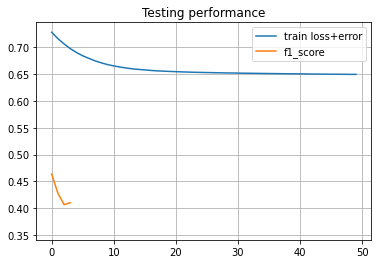

In [ ]:
loss, acc, f1 = abModel.evaluate(test_Ab_pred, testAb_labels)
p3 = abModel.predict(test_Ab_pred)
print("Loss: ", loss)
print('Accuracy: ', acc)                                  
plt.figure()
plt.grid()                                                                                                      
plt.title('Testing performance')                          
plt.plot(h.epoch, h.history['loss'], label='train loss+error')  
plt.plot(h.epoch, h.history['f1_score'], label='f1_score')
plt.legend()

In [ ]:
del train_Ab_pred
del abModel